## 0. Understanding the Problem

The process of classifying the authors for a given text is called authorship attribution. Each author writes about different topics and has their own style of writing (author fingerprint) which allows for the identification. Applications of this kind of model include plaigarism detection and resolving the disputed authorship. 

In the dataset given there are 2 columns: Author and Text
This makes it a supervised learning problem since there is data and a assigned label  to each text. 

In the problem, the cost of false positive and false negatives both carry significant consequences. Therefore, a good model should have a balance of sensitivity and specificity. F1-score would be the ideal metric for the model evaluation

## 1. Installing and Importing Packages

In [1]:
# %pip install openpyxl --upgrade
# %pip install textstat

In [2]:
import re
import pandas as pd
from pprint import pprint
import numpy as np
import seaborn as sns
import string
from nltk.corpus import stopwords
from nltk import bigrams, trigrams, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import MWETokenizer
import matplotlib.pyplot as plt
import textstat
import warnings
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
palette = "cool"

## DATA UNDERSTANDING

In [3]:
df_train = pd.read_excel("Assignment_Data/Data.xlsx")

df_train.head()

,Text,Author
0,Scoring in PROC DISCRIM is as easy as validati...,AM
1,"In the GLM procedure, you may have used LSMEAN...",AM
2,"The first problem, accuracy of the data file, ...",AM
3,If the homogeneity of covariance matrices assu...,AM
4,"With a CONTRAST statement, you specify L, in t...",AM


In [4]:
df_train.shape

(1922, 2)

In [5]:
df_train.info()
# no null values in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1922 entries, 0 to 1921
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    1922 non-null   object
 1   Author  1922 non-null   object
dtypes: object(2)
memory usage: 30.2+ KB


In [6]:
# check for duplicates in the text data 
duplicate_data = df_train.duplicated(keep="first")

print(duplicate_data.sum(), "duplicate rows are present within the data")


display(df_train[duplicate_data].sort_values(by="Text").head(8))

1106 duplicate rows are present within the data


,Text,Author
1367,"%distribution(data=&data,out=&report_name,cont...",DM
1419,"%distribution(data=&data,out=&report_name,cont...",DM
1414,"%generate_grouping(from=work.profile_codes,val...",DM
1243,"%generate_grouping(from=work.profile_codes,val...",DM
1362,*\tTemporal infidelity occurs when model input...,DM
1370,*\tTemporal infidelity occurs when model input...,DM
248,*\texamining group differences on predictor va...,AM
44,*\texamining group differences on predictor va...,AM


In [7]:
# remove the duplicate rows within the dataset
df_train.drop_duplicates(inplace=True)
display(df_train.shape)

(816, 2)

<div class="alert alert-info" role="alert">
    There's quite a lot of duplicated rows present. These will be unhelpful for training the model and need to be removed.
</div>

In [8]:
df_train["text_length"] = df_train.Text.apply(len)
df_train.head()

,Text,Author,text_length
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215
1,"In the GLM procedure, you may have used LSMEAN...",AM,782
2,"The first problem, accuracy of the data file, ...",AM,990
3,If the homogeneity of covariance matrices assu...,AM,934
4,"With a CONTRAST statement, you specify L, in t...",AM,1490


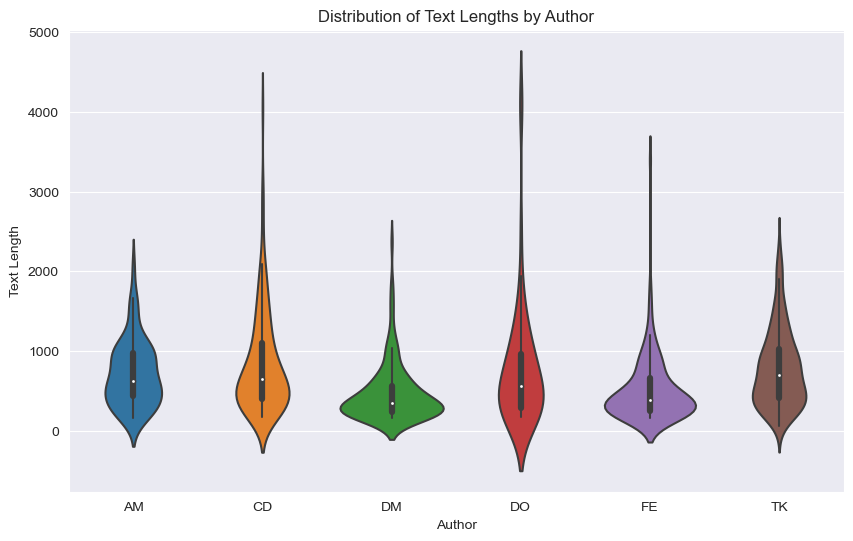

In [9]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=df_train, x="Author", y="text_length", element="poly");
ax.set_title('Distribution of Text Lengths by Author');
ax.set_ylabel('Text Length');

<div class="alert alert-info" role="alert">
    --> Shows that some authors like AM and DM tend to write shorter texts. This could be a distinguishing feature in the model.<br>
    --> Looks like majority of the text lengths are around 400 - 500 characters with slight differences. <br>
    --> This is not a strong feature in the classification, other features need to be looked at.
</div>

In [10]:
# function to count the number of words inside a sentence
def word_counter(sent):
    return len(sent.split(" "))

df_train["word_count"] = df_train["Text"].apply(word_counter)

df_train.head()

,Text,Author,text_length,word_count
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129
2,"The first problem, accuracy of the data file, ...",AM,990,159
3,If the homogeneity of covariance matrices assu...,AM,934,146
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247


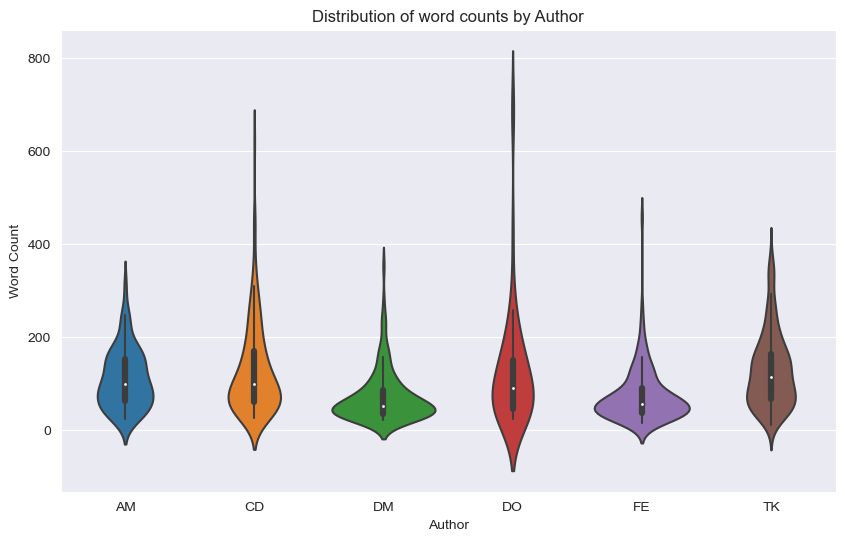

In [11]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=df_train, x="Author", y="word_count", element="poly");
ax.set_title('Distribution of word counts by Author');
ax.set_ylabel('Word Count');

<div class="alert alert-info" role="alert">
    --> Both word count and text length are highly correlated features. 
</div>

In [12]:
# getting the average word length

def avg_word_length(sent): 
    sent_len = len(sent.split(" "))
    return sum([len(wrd)  for wrd in sent]) / sent_len

df_train["avg_word_length"] = df_train["Text"].apply(avg_word_length)

df_train.head()

,Text,Author,text_length,word_count,avg_word_length
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389


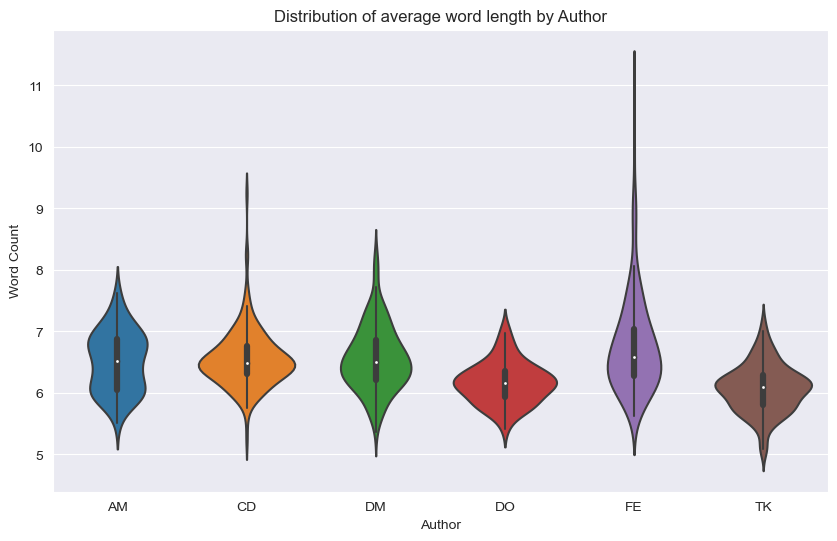

In [13]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=df_train, x="Author", y="avg_word_length", element="poly");
ax.set_title('Distribution of average word length by Author');
ax.set_ylabel('Word Count');

<div class="alert alert-info" role="alert">
    --> This can be a good distinguishing feature since each autho has different average word lengths.<br>
    --> Presence of outliers in author texts like FE indicates the usage of unique vocabulary.
</div>

In [14]:
# # adding a type-token ratio feature to check the lexical richness of the text, it is measured by looking at the ratio of the unique tokens to the total number of tokens used within the text. 

# # the aim is to look at the lexical richness of each author's texts by grouping by the author name.


def text_tokenizer(sent):
    lemmatizer = WordNetLemmatizer()
    sent = sent.lower() # convert the text to lowercase
    tokens = re.split(r'\W+', sent) # split text based on non word characters
    clean_tokens = [lemmatizer.lemmatize(i) for i in tokens if i not in string.punctuation or not i.isdigit()] # removing number, punctuation and lemmatizing the text
    clean_tokens_no_stopwords = [i for i in clean_tokens if i not in stopwords.words('english')]
    return clean_tokens_no_stopwords
    
    
def lexical_diversity(text):
    tokens = text_tokenizer(text)
    types = len(set(tokens))
    return types / len(tokens) if tokens else 0


# df_train['Lexical_Diversity'] = df_train['Text'].apply(lexical_diversity)
# author_lexical_diversity = df_train.groupby('Author')['Lexical_Diversity'].mean()


# # Display the results
# author_lexical_diversity.sort_values(ascending=False)

In [15]:
# # looking at the row with the smallest type to token ratio. 
# small_ttt = df_train["type_to_token"].argmin()
# df_train.iloc[small_ttt]

In [16]:
df_train["comma_count"] = df_train["Text"].str.count(",")
df_train.head()

,Text,Author,text_length,word_count,avg_word_length,comma_count
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811,0
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016,4
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415,6
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260,4
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389,8


In [18]:
def count_exclamations(text):
    return text.count('!')

df_train['exclamation_count'] = df_train['Text'].apply(count_exclamations)
df_train.head()

,Text,Author,text_length,word_count,avg_word_length,comma_count,exclamation_count
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811,0,0
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016,4,0
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415,6,1
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260,4,0
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389,8,0


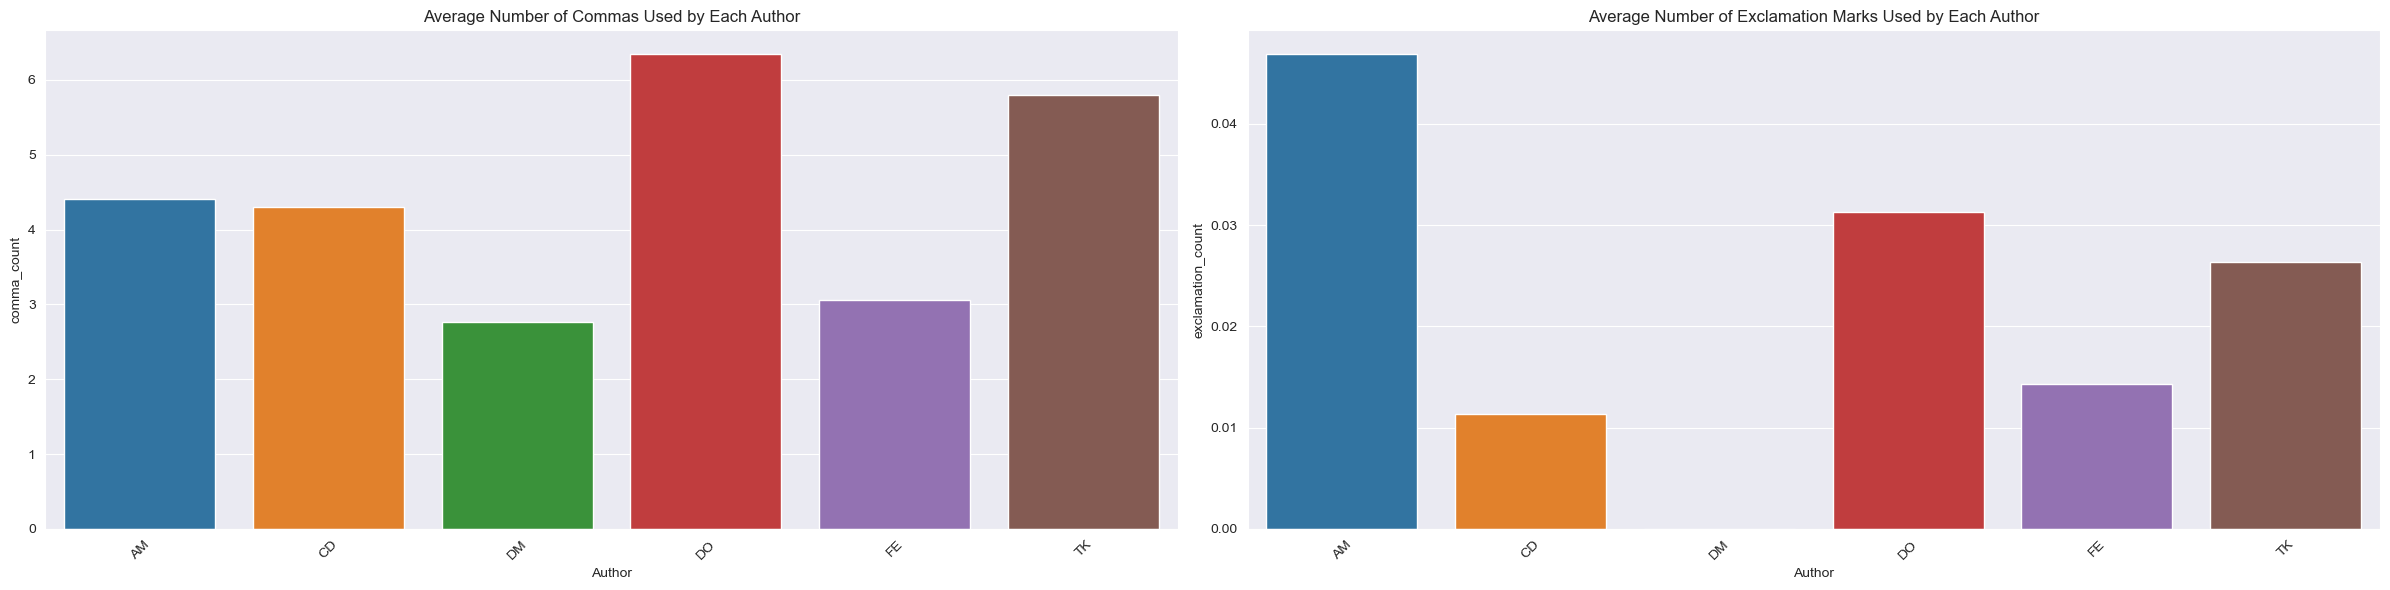

In [31]:
author_punctuation = df_train.groupby('Author').agg({'comma_count': 'mean', 'exclamation_count': 'mean'}).reset_index()
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# Comma usage bar chart
sns.barplot(ax=axes[0], x='Author', y='comma_count', data=author_punctuation)
axes[0].set_title('Average Number of Commas Used by Each Author')
axes[0].tick_params(axis='x', rotation=45)

# Exclamation usage bar chart
sns.barplot(ax=axes[1], x='Author', y='exclamation_count', data=author_punctuation)
axes[1].set_title('Average Number of Exclamation Marks Used by Each Author')
axes[1].tick_params(axis='x', rotation=45)

# Display the subplots
plt.tight_layout()
plt.show()

In [16]:
def avg_sentence_length(txt):
    sents = re.split(r'[.!?]+', txt)
    sents = [i.strip() for i in sents if i.strip()]
    word_counts = [len(i.split()) for i in sents]

    if len(word_counts) > 0:
        return sum(word_counts) / len(word_counts)
    else:
        return 0
    
df_train['avg_sentence_length'] = df_train['Text'].apply(avg_sentence_length)

In [33]:
df_train.head()

,Text,Author,text_length,word_count,avg_word_length,comma_count,avg_sentence_length,POS_Nouns,POS_Verbs,flesch_reading_score,unique_word_count,exclamation_count,gunning_fog_index
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811,0,12.333333,0.305556,0.166667,58.99,28,0,10.33
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016,4,18.428571,0.286822,0.093023,52.80,71,0,11.39
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415,6,16.000000,0.234177,0.158228,46.88,95,1,11.39
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260,4,18.250000,0.312925,0.081633,44.44,70,0,11.98
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389,8,15.687500,0.282869,0.127490,55.54,95,0,9.15


In [18]:
import spacy

nlp = spacy.load("en_core_web_sm") # spacy english model


def pos_proportions(text, pos_tag):
    doc = nlp(text)
    pos_counts = 0
    total_words = 0
    for token in doc:
        if token.is_alpha:
            total_words += 1
        if token.pos_ == pos_tag:
            pos_counts += 1
    return pos_counts / total_words if total_words > 0 else 0


# counting proportion of words which are nouns
df_train['POS_Nouns'] = df_train['Text'].apply(lambda x: pos_proportions(x, "NOUN"))
# counting proporiton of words which are everbs
df_train['POS_Verbs'] = df_train['Text'].apply(lambda x: pos_proportions(x, "VERB"))


df_train.head()

,Text,Author,text_length,word_count,avg_word_length,comma_count,avg_sentence_length,POS_Nouns,POS_Verbs
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811,0,12.333333,0.305556,0.166667
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016,4,18.428571,0.286822,0.093023
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415,6,16.000000,0.234177,0.158228
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260,4,18.250000,0.312925,0.081633
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389,8,15.687500,0.282869,0.127490


In [19]:
def flesch_reading_score(text):
    return textstat.flesch_reading_ease(text)


df_train['flesch_reading_score'] = df_train['Text'].apply(flesch_reading_score)

df_train.head()

,Text,Author,text_length,word_count,avg_word_length,comma_count,avg_sentence_length,POS_Nouns,POS_Verbs,flesch_reading_score
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811,0,12.333333,0.305556,0.166667,58.99
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016,4,18.428571,0.286822,0.093023,52.80
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415,6,16.000000,0.234177,0.158228,46.88
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260,4,18.250000,0.312925,0.081633,44.44
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389,8,15.687500,0.282869,0.127490,55.54


In [20]:
def unique_word_count(text):
    words = text_tokenizer(text)
    return len(set(words))

df_train['unique_word_count'] = df_train['Text'].apply(unique_word_count)
df_train.head()

,Text,Author,text_length,word_count,avg_word_length,comma_count,avg_sentence_length,POS_Nouns,POS_Verbs,flesch_reading_score,unique_word_count
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811,0,12.333333,0.305556,0.166667,58.99,28
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016,4,18.428571,0.286822,0.093023,52.80,71
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415,6,16.000000,0.234177,0.158228,46.88,95
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260,4,18.250000,0.312925,0.081633,44.44,70
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389,8,15.687500,0.282869,0.127490,55.54,95


In [22]:
df_train['gunning_fog_index'] = df_train['Text'].apply(textstat.gunning_fog)
df_train.head()

,Text,Author,text_length,word_count,avg_word_length,comma_count,avg_sentence_length,POS_Nouns,POS_Verbs,flesch_reading_score,unique_word_count,exclamation_count,gunning_fog_index
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811,0,12.333333,0.305556,0.166667,58.99,28,0,10.33
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016,4,18.428571,0.286822,0.093023,52.80,71,0,11.39
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415,6,16.000000,0.234177,0.158228,46.88,95,1,11.39
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260,4,18.250000,0.312925,0.081633,44.44,70,0,11.98
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389,8,15.687500,0.282869,0.127490,55.54,95,0,9.15


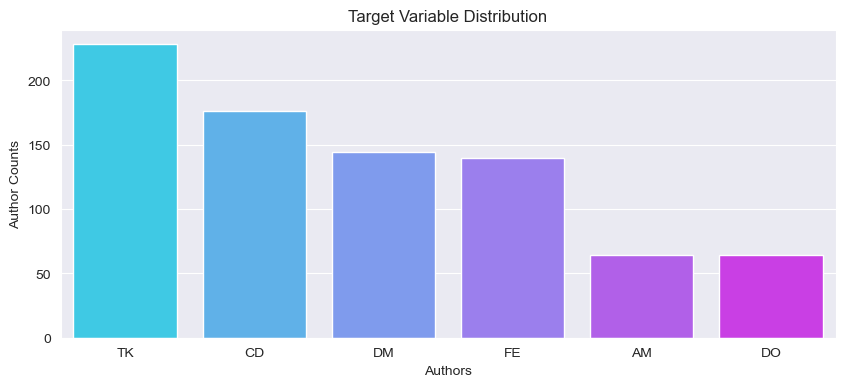

In [23]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df_train, x="Author", order=df_train["Author"].value_counts().index, palette=palette);
plt.title("Target Variable Distribution");
plt.ylabel("Author Counts");
plt.xlabel("Authors");
plt.xticks();

<div class="alert alert-info" role="alert">
    Data is imbalanced. There are 2 ways that we can handle this: <br>
    1. Perform a combination of oversampling and undersampling techniques <br>
    2. Make use of a metric that accounts for the class imbalance. In our case we will look at the weighted average f1 score as it accounts for this.
</div>

In [ ]:
text = " ".join(df_train.Text)

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<div class="alert alert-info" role="alert">
At first glance it can be seen that: 
    <br>
    -> Most important words: "Model", "Data", "Analysis", "Variable" <br>
    -> Stopwords: "One", "May", "Even", "Must"
</div>

In [ ]:
# look at words each author has written

author_texts = {author: " ".join(df_train[df_train['Author'] == author]['Text']) for author in df_train.Author.unique()} # all the texts written by author

num_authors = len(author_texts)
num_rows = num_authors // 2 + num_authors % 2

plt.figure(figsize=(16, 5 * num_rows)) # to show the wordclouds as subplots for easier viewing


for i, (author, text) in enumerate(author_texts.items(), start=1):
    wordcloud = WordCloud().generate(text)
    plt.subplot(num_rows, 2, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Text by {author}", fontsize=30)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">
At first glance it can be seen that each author is speaking about different topics: 
    <br>
    -> AM: talks about statistical classification techniques, discussing things such as discriminant analysis, group differences, and variable selection <br>
    -> CD: talks about machine learning and probability concepts like logistic regression, odds ratios, model estimation, predictor variable <br>
    -> DM: talks about data modeling, specifically addressing the management and analysis of transactional data sets <br>
    -> DO: talks about experimental design and topics like block design and factorial experiements <br>
    -> FE: talks about time series forecasting with topics like PROC, ARIMA and forecast <br>
    -> TK: talks about societal impact, with topics like society, psychological, and people.
</div>

## DATA PREPARATION

In [ ]:
def text_preprocessing(txt):
    lemmatiser = WordNetLemmatizer()
    txt_clean = txt.replace('\t', ' ').replace('\n', ' ')
    txt_tokens = txt_clean.split(" ")
    txt_lowercase = [word.lower() for word in txt_tokens]
    txt_no_punctuation = [word.translate(str.maketrans('', '', string.punctuation)) for word in txt_lowercase]
    txt_lemmatize = [lemmatiser.lemmatize(word) for word in txt_no_punctuation]
    txt_no_stopwords = [word for word in txt_lemmatize if word not in stopwords.words('english') and word != ""]
    return txt_no_stopwords

In [ ]:
df_train["preprocessed_text"] = df_train["Text"].apply(lambda x: text_preprocessing(x))
df_train.head()

In [ ]:
grouped = df_train.groupby('Author')['preprocessed_text'].sum()

for author, words in grouped.items():
    text = ' '.join(words)
    wordcloud = WordCloud().generate(text)
    plt.figure(figsize = (8, 8)) 
    plt.subplot(122)
    plt.imshow(wordcloud) 
    plt.title(f"Text by {author}")
    plt.axis("off")
    plt.tight_layout(pad = 0) 
    plt.show()

In [ ]:
all_tokens = sum(df_train['preprocessed_text'], [])
unigram_freq = FreqDist(all_tokens)

unigrams, counts = zip(*unigram_freq.most_common(15))
plt.barh(unigrams, counts)
plt.title('TOP 15 UNIGRAMS')
plt.show()

In [ ]:
all_bigrams = list(bigrams(all_tokens))
bigram_freq = FreqDist(all_bigrams)
print(bigram_freq.most_common(10))

bigrams, counts = zip(*bigram_freq.most_common(15))
bigram_labels = [' '.join(bigram) for bigram in bigrams]
plt.barh(bigram_labels, counts)
plt.title('Top 15 BIGRAMS')
plt.figure(figsize = (15, 15))
plt.show()

In [ ]:
all_trigrams = list(trigrams(all_tokens))
all_trigrams
trigram_freq = FreqDist(all_trigrams)
print(trigram_freq.most_common(15))

trigrams, counts = zip(*trigram_freq.most_common(15))
trigram_labels = [' '.join(trigram) for trigram in trigrams]
plt.barh(trigram_labels, counts)
plt.title('TOP 15 TRIGRAMS')
plt.figure(figsize = (15, 15))
plt.show()

In [ ]:
compound_words = [i[0] for i in bigram_freq.most_common(15)]
compound_words += [('logistic', 'regression', 'model')]
mwe_tokenizer = MWETokenizer(compound_words, separator="_")
mwe_tokenizer

In [ ]:
# use this to update the tokens with compound words found from the bigram analysis
# also remove special characters and numbers
def apply_mwe_to_tokens(row):
    tokens = mwe_tokenizer.tokenize(row)
    cleaned_tokens = [token.replace('\t', '') for token in tokens if not token.isnumeric()]
    return cleaned_tokens

df_train['preprocessed_text'] = df_train['preprocessed_text'].apply(apply_mwe_to_tokens)
df_train.head()

In [ ]:
df_train.to_csv("cleaned_data.csv")